In [1]:
# Imports
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PlotSinglePosterior
from sklearn.model_selection import train_test_split


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
print("Pytorch version: " + torch.__version__)
print("ROCM HIP version: " + torch.version.hip)
torch.cuda.set_device('cuda:0')

import synthesizer
from synthesizer.parametric import Galaxy
from synthesizer.emission_models import PacmanEmission, TotalEmission, EmissionModel, IntrinsicEmission, StellarEmissionModel, STELLAR_MODELS, IncidentEmission
from synthesizer.emission_models.attenuation import PowerLaw,  Calzetti2000
from synthesizer.emissions import plot_spectra
from synthesizer.emission_models.dust.emission import Greybody
from synthesizer.grid import Grid
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.parametric import SFH, Stars, ZDist
from synthesizer.filters import FilterCollection
from synthesizer.instruments import Instrument

from typing import Dict, Any, List, Tuple, Union, Optional, Type
from abc import ABC, abstractmethod
import copy

from scipy.stats import uniform, loguniform

from astropy.io import ascii
from unyt import unyt_array, unyt_quantity, erg, cm, s, Angstrom, um, Hz, m, nJy, K, Msun, Myr, yr, Unit, kg, Jy
from unyt.equivalencies import SpectralEquivalence

from astropy.cosmology import Planck18, Cosmology, z_at_value
from synthesizer.emission_models.attenuation import Inoue14
import astropy.units as u
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from tqdm import tqdm

print(ili.__file__)
print(synthesizer.__file__)

from ltu_ili_testing import generate_emission_models, generate_sfh_basis, generate_metallicity_distribution, generate_constant_R

from synthesizer import check_openmp
check_openmp()

Device: cuda
Pytorch version: 2.4.1
ROCM HIP version: 6.1.40093-e3dc58bf0
/home/tharvey/work/ltu-ili/ili/__init__.py
/home/tharvey/work/synthesizer/src/synthesizer/__init__.py
Device: cuda
Pytorch version: 2.4.1
ROCM HIP version: 6.1.40093-e3dc58bf0


True

### Environment Notes

Many CUDA/ROCm packages in pyproject.toml are pinned specifically to compiled versions on my machine so the GPU works.
Had to downgrade numpy <2.0 for harmonic. Unclear if this will cause other issues.

ili is installed as editable.

### Setup Filters

In [2]:

filter_codes = [
    "JWST/NIRCam.F090W",
    "JWST/NIRCam.F115W",
    "JWST/NIRCam.F150W",
    "JWST/NIRCam.F162M",
    "JWST/NIRCam.F182M",
    "JWST/NIRCam.F200W",
    "JWST/NIRCam.F210M",
    "JWST/NIRCam.F250M",
    "JWST/NIRCam.F277W",
    "JWST/NIRCam.F300M",
    "JWST/NIRCam.F335M",
    "JWST/NIRCam.F356W",
    "JWST/NIRCam.F410M",
    "JWST/NIRCam.F444W",
]

filterset = FilterCollection(filter_codes)



instrument = Instrument('JWST', filters=filterset)


What is a sensible formulation of an alternative model?

Could generalize over a basic grid derived model. E.g. range of metallicities - from supersolar to subsolar, range of SFH ages, range of dust attenuation. Fixed dust law. Fixed or varying ionization parameter? Don't really care about normalization so mass doesn't matter. 

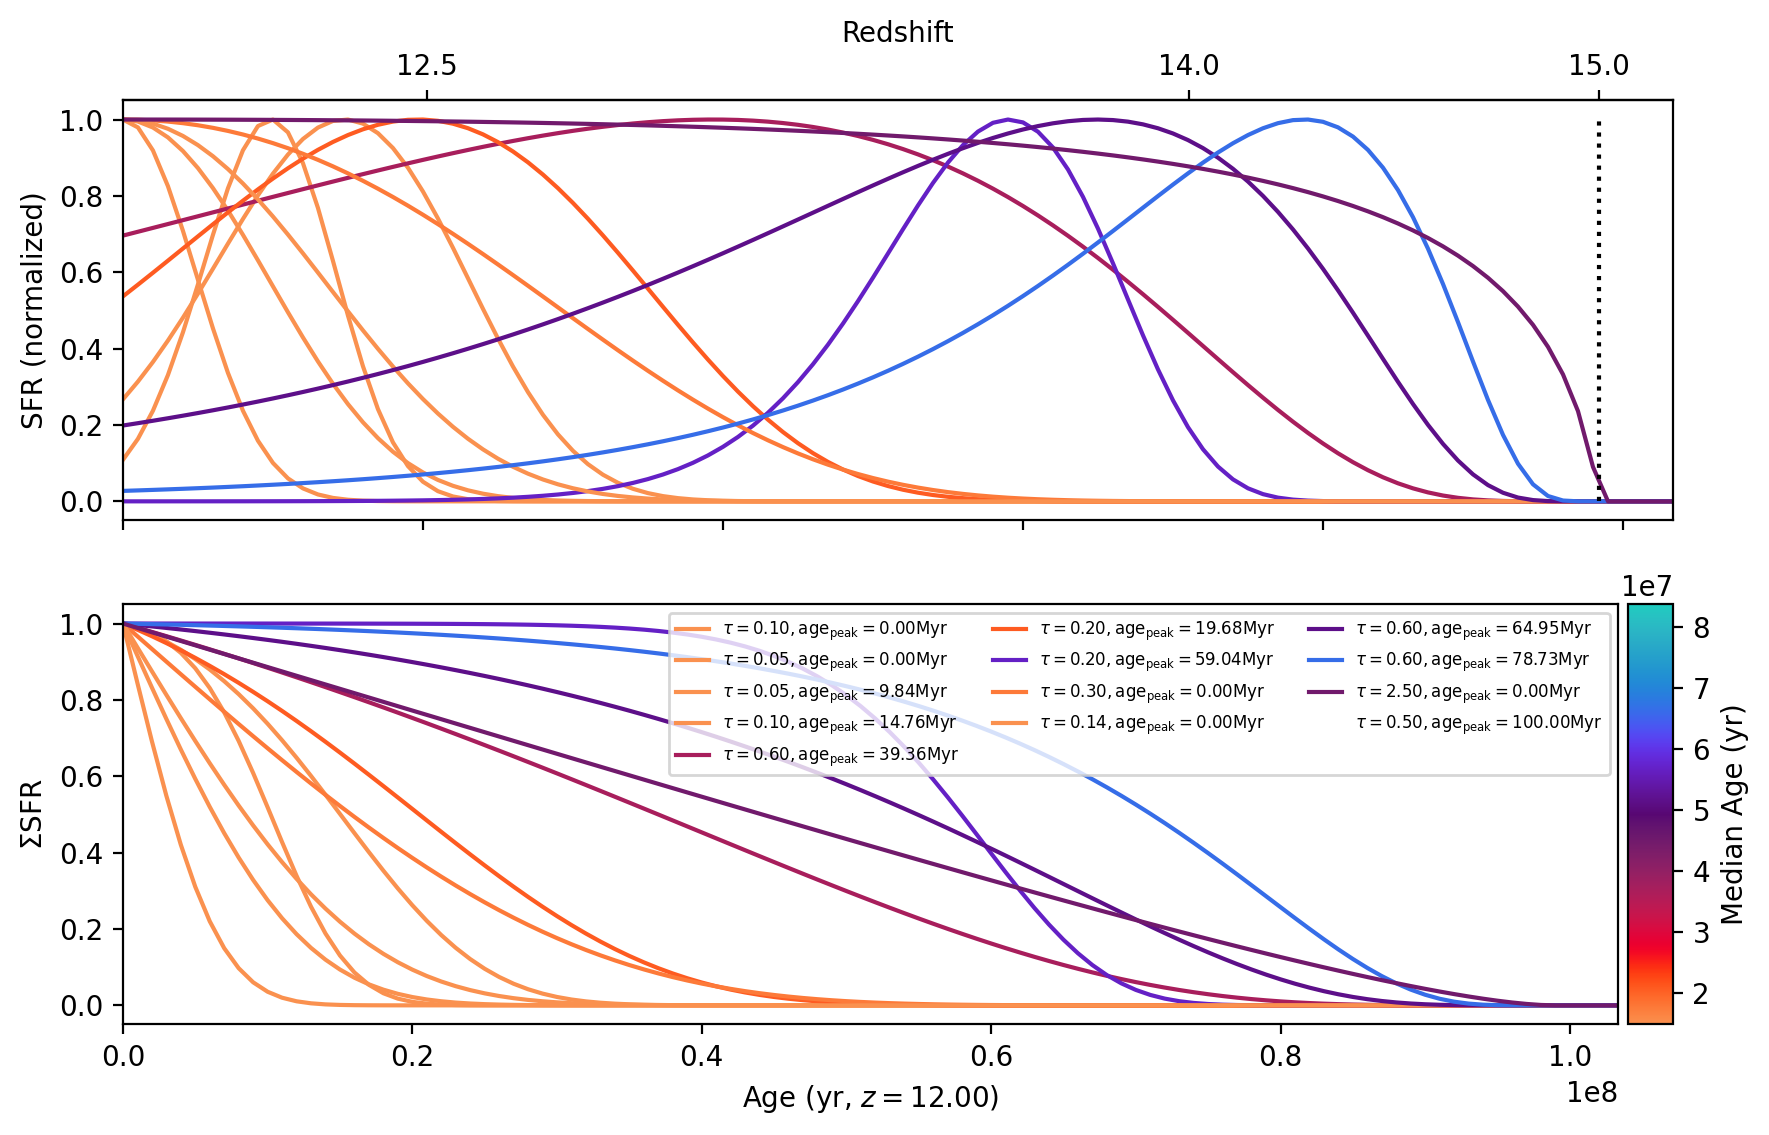

In [73]:
redshift = 12

from cmasher import take_cmap_colors
import cmasher
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable



max_redshift = 15

max_age = (Planck18.age(redshift) - Planck18.age(max_redshift)).to(u.Myr).value * Myr

taus = np.linspace(0, 2.0, 10)
peak_ages = np.linspace(-100*Myr, max_age, 5) 

cmap = 'cmr.guppy'
cmap = plt.get_cmap(cmap)



norm = Normalize(vmin=0.15*max_age.to(yr).value, vmax=0.85*max_age.to(yr).value)

# Define parameter grid
taus = np.array([0.1, 0.2, 0.5, 1.0, 1.5, 2.5])  # Width parameter

# For peak ages, using fractional values of max_age helps with interpretation
peak_age_fractions = np.array([ -0.2, -0.05, 0.1, 0.4, 0.7, 0.9])
peak_ages = peak_age_fractions * max_age

# Create the parameter grid
tau_grid, peak_age_grid = np.meshgrid(taus, peak_ages)

# broadcast the two arrays to get every possible combination

tau_array, peak_age_array = np.meshgrid(taus, peak_ages)
tau_values = tau_array.flatten()
peak_age_values = peak_age_array.flatten()



# Define tau values and corresponding peak_age values in terms of max_age

tau_peak_keep = np.array([    
        (0.1, 0),  # Recent burst, rising SFH
        (0.05, 0), # Very recent burst           
        (0.05,  lambda max_age: 0.1*max_age), # Very recent burst       
        (0.1,  lambda max_age: 0.15*max_age), # older burst, declining SFH
        (0.6,  lambda max_age:0.4*max_age), # Fairly flat, slight decline 
        (0.2,  lambda max_age: 0.2*max_age), # Fairly flat, slight decline 
        (0.2,  lambda max_age:0.6*max_age), # Quiescent 
        (0.3, 0), # slowly rising
        (0.14,  0), # medium rising
        (0.6,  lambda max_age: 0.66 * max_age),
        (0.6,  lambda max_age: 0.8 * max_age),# early burst, now quiescent
        (2.5,  lambda max_age: 0 * max_age), # early and constant
        (0.5,  100), # early and constant
])

tau_values = tau_peak_keep[:, 0]
peak_age_values = tau_peak_keep[:, 1]


def plot_lognorm_sfh(tau_values, peak_age_values):

    tau_values = np.atleast_1d(tau_values)
    peak_age_values = np.atleast_1d(peak_age_values)


    fig, axs = plt.subplots(2, 1, figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k', sharex=True)
    ax = axs[0]
    for i in range(len(tau_values)):
        tau = tau_values[i]
        peak_age = peak_age_values[i]
        if callable(peak_age):
            peak_age = peak_age(max_age) 
        else:
            peak_age = peak_age * Myr

        sfh = SFH.LogNormal(tau=tau, peak_age=peak_age, max_age=max_age, min_age=0*Myr)
        med_age = sfh.calculate_mean_age(dt=1e5)
        age, sfr = sfh.calculate_sfh(t_range=(0, 1.1*max_age.to(yr)), dt=1e6)                                       
        sfr = sfr / sfr.max()
        ax.plot(age, sfr, label=f"tau={tau:.2f}, peak_age={peak_age:.2f}", color=cmap(norm(med_age)))
        # plot cumulative on axs[1]

        mass_formed = np.cumsum(sfr[::-1])[::-1]/np.sum(sfr)

        axs[1].plot(age, mass_formed, color=cmap(norm(med_age)), label=rf'$\tau = {tau:.2f}, \rm age_{{peak}} = {peak_age:.2f}$')
        

    axs[1].set_xlabel(f"Age (yr, $z={redshift:.2f}$)")
    ax.set_ylabel("SFR (normalized)")
    ax.set_xlim(0, 1.05*max_age.to(yr))

    # import make_axes_divisble

    cax = make_axes_locatable(axs[1]).append_axes("right", size="3%", pad=0.05)


    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1], cax=cax)
    cax.set_ylabel('Median Age (yr)')

    # Get current xticks, calculate what they would be in age of universe using the cosmology, then convert that to redshift. Add redshift ticks

    cosmo = Planck18

    def time_convert(lookback_time):
        lookback_time = lookback_time * u.yr
        return z_at_value(
            cosmo.lookback_time,
            cosmo.lookback_time(redshift) + lookback_time,
        ).value

    def z_convert(z):
        if type(z) in [list, np.ndarray] and len(z) == 0:
            return np.array([])
        
        return (
            cosmo.lookback_time(z) - cosmo.lookback_time(redshift)
        ).to(u.yr).value

    axs[1].legend(loc='upper right', fontsize=6, ncols=3)

    secax = ax.secondary_xaxis("top", functions=(time_convert, z_convert))
    secax.set_xlabel(f"Redshift")

    # Put a vertical line at maximum redshift

    secax.set_xticks([6, 7, 8, 10, 12, 12.5, 14, 15, 20])

    ax.vlines(max_age.to(yr), 0, 1, color='black', linestyles='dotted')

    axs[1].set_ylabel(r'$\Sigma \rm SFR$')

plot_lognorm_sfh(tau_values, peak_age_values)


In [8]:
# General
grid = Grid('bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps.hdf5',
            grid_dir='/home/tharvey/work/synthesizer_grids/',
            new_lam=new_wav)


popIII_grid = Grid('yggdrasil-1.3.3-PopIII_salpeter-10,1,500',
                    grid_dir='/home/tharvey/work/synthesizer_grids/',
                    read_lines=False, new_lam=new_wav)

# Salpeter 50 - 500 Msun - 0.01 to 3.6 Myr
# Salpeter 10, 1, 500 - 0.01 to 1000 Myr
# Kroupa 0.1, 100 - 0.01, 3162 Myr


max_redshift = 20 # gives maximum age of SFH at a given redshift
redshift = np.arange(6, 15, 1)   #={'prior': uniform, 'min': 5, 'max': 15, 'size': 10}
cosmo = Planck18 # cosmology to use for age calculations

# Metallicity 
Z_dist = ZDist.DeltaConstant
min_logZ = -3 # minimum log10 metallicity
max_logZ = 0.3 # maximum log10 metallicity
N_Z = 5 # number of metallicity distributions to generate

# SFH parameters
min_mass = 6 # minimum log10 stellar mass
max_mass = 11 # maximum log10 stellar mass
mass_step = 1.0 # step in stellar mass
sfh_type = SFH.LogNormal

sfh_param_names = ['tau', 'peak_age']
tau_peak = np.array([    
        (0.1, -300),  # Recent burst, rising SFH
        (0.05, -300), # Very recent burst           
        (0.05,  lambda max_age: 0.1*max_age), # Very recent burst       
        (0.1,  lambda max_age: 0.15*max_age), # older burst, declining SFH
        (0.6,  lambda max_age:0.4*max_age), # Fairly flat, slight decline 
        (0.2,  lambda max_age: 0.2*max_age), # Fairly flat, slight decline 
        (0.2,  lambda max_age:0.6*max_age), # Quiescent 
        (0.3, -50), # slowly rising
        (0.14,  -50), # medium rising
        (0.6,  lambda max_age: 0.66 * max_age),
        (0.6,  lambda max_age: 0.8 * max_age),# early burst, now quiescent
        (2.5,  lambda max_age: -0.5*max_age), # early and constant
        (0.5,  100), # early and constant

])
sfh_param_units = [None, Myr]


sfh_models, redshifts = generate_sfh_basis(
    sfh_type=sfh_type,
    sfh_param_names=sfh_param_names,
    sfh_param_arrays=tau_peak,
    redshifts=redshift,
    max_redshift=max_redshift,
    cosmo=cosmo,
    sfh_param_units=sfh_param_units,
)

# Emission model

emission_model = TotalEmission
dust_curve = PowerLaw(slope=-1)
fesc = 0.1
fesc_ly_alpha = 0.1
dust_emission_model = None


emission_models, varying_params = generate_emission_models(
    emission_model=emission_model,
     grid=grid,
    varying_params={
        'tau_v': {
            'prior': loguniform, 
            'a': 1e-3, 
            'b': 1.0, 
            'size': 10, 
            'units': None,
            'name': 'tau_v'
        },
    },
    fixed_params={
        'dust_curve': dust_curve,
        'fesc': fesc,
        'fesc_ly_alpha': fesc_ly_alpha,
        'dust_emission_model': dust_emission_model,
    }
)

print(varying_params)

Z_dists = [Z_dist(log10metallicity=i) for i in np.linspace(min_logZ, max_logZ, N_Z)]


# Pop III parameters
sfh_array = np.array([(0, 10), (0, 20), (0, 30), (10, 20), (10, 30), (20, 30), (30, 50), (50, 70), (70, 100)]) 
sfh_param_units = [Myr, Myr]
popIII_sfhs, _ = generate_sfh_basis(
    sfh_type=SFH.Constant,
    sfh_param_names=['min_age', 'max_age'],
    sfh_param_arrays=sfh_array,
    redshifts=redshift,
    max_redshift=max_redshift,
    cosmo=cosmo,
    sfh_param_units=sfh_param_units,
    calculate_min_age=True,
)

popIII_metal_dist = ZDist.DeltaConstant(metallicity=0)
popIII_emission_model = IncidentEmission(
    grid=popIII_grid,
)

sed_grid_gen = sed_grid_generator(
    sps_grid=grid,
    instrument=filterset,
    cosmo=cosmo,
    redshifts=redshifts,
    emission_models=emission_models,
    sfhs=sfh_models,
    metal_dists=Z_dists,
    logm_range=(min_mass, max_mass, mass_step),
    truncate_sfh_at_z=max_redshift,
    popIII_sfhs=popIII_sfhs,
    popIII_sps_grid=popIII_grid,
    popIII_metal_dists=[popIII_metal_dist],
    popIII_emission_models=[popIII_emission_model],
    mass_fraction_range=(0, 1.1, 0.1),
    emission_keys = {'Pop II':'total', 'Pop III':'incident'}
    
)

# in this case varying params are

# tau_v, redshift, mass, popIII_mass_fraction, tau, peak_age, logZ, min_popIII_age, max_popIII_age.

# ranges are approximately 1e-3 to 2.0 for tau_v, 5 to 15 for redshift, 6 to 11 for mass, 0 to 1 for popIII_mass_fraction, 
# 0.05 to 2.5 for tau, -500 to 500 for peak_age, -3 to 0.3 for logZ, 0 to 100 for min_popIII_age, 0 to 100 for max_popIII_age.

# For this current version this is 2.4 million models.

# Ways to do this more simply for an initial test.
# Cut redshift range down to 1 to 3 bins at lower-redshift.
# Cut SFHs down to a few recent bursts. Don't want to teach the model that Pop III stars should exist after Pop II stars.


'''
sed_grid = sed_grid_gen.generate_grid()

# Base grid will just be photometry. redshifts. Info about model can be stored in the file as well as SEDs. 

sed_grid_gen.save_to_hdf5(
    sed_grid,
    filename='sed_grid.hdf5',
    groupname='sed_grid',
    overwrite=True,
)
'''



for i in range(100):
    # Draw a random SED and plot it
    fig = sed_grid_gen.draw_random_sed(plot=True, seed=i)
    fig.savefig(f'../plots/random_sed_{i}.png')
    plt.close(fig)




10it [00:00, 1678.26it/s]


{'tau_v': [0.189905786561886, 0.009464123445503488, 0.24519622545189518, 0.5508915628809571, 0.01514992328232474, 0.005938654368479403, 0.11329931745681884, 0.36373951020254996, 0.053103943040900964, 0.0010518916629099714]}


In [13]:
# make gif of everything in the plots directory

import imageio
import os

files = os.listdir('../plots')
files = [f for f in files if f.endswith('.png')]
files.sort(key=lambda x: int(x.split('_')[2].split('.')[0]))  # Sort by the number in the filename
images = []
for file in files:
    images.append(imageio.imread(os.path.join('../plots', file)))
imageio.mimsave('../plots/random_sed.gif', images, duration=1000)
# remove all the png files
'''for file in files:
    os.remove(os.path.join('plots', file))
 '''   

#

"for file in files:\n    os.remove(os.path.join('plots', file))\n "

In [16]:

new_wav = generate_constant_R(R=300, start=92*Angstrom, end=90165900*Angstrom)

print(len(new_wav))

popIII_grid = Grid('yggdrasil-1.3.3-PopIII_salpeter-10,1,500.hdf5', #'bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps.hdf5',
                    grid_dir='/home/tharvey/work/synthesizer_grids/',
                    read_lines=False,
                    new_lam=new_wav)

print(f'Resampled grid: {len(popIII_grid.lam)}')


grid = Grid('yggdrasil-1.3.3-PopIII_salpeter-10,1,500.hdf5', #'bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps.hdf5',
                    grid_dir='/home/tharvey/work/synthesizer_grids/',
                    read_lines=False,
)

print(f'Original grid: {len(grid.lam)}')

galaxy = Galaxy(
    stars = Stars(
        popIII_grid.log10age,
        popIII_grid.metallicity,
        sf_hist = SFH.Constant(max_age=100*Myr),
        initial_mass = 1e9 * Msun,
        metal_dist = ZDist.DeltaConstant(metallicity=0),
    ),
)

emission_model = IncidentEmission(
    grid = popIII_grid,
    dust_curve=PowerLaw(slope=-1),
    tau_v=0,
)


galaxy.stars.get_spectra(emission_model)

print(f"Using get_spectra {len(galaxy.stars.spectra['incident'].lnu)}")

galaxy.stars.spectra = {}

from synthesizer.pipeline import Pipeline
pipeline = Pipeline(
            emission_model=emission_model,
            instruments=instrument,
            nthreads=1,
            verbose=False,
)

pipeline.add_galaxies([galaxy])

pipeline.get_spectra()

pipeline.run()

pipeline.lnu_spectra

8286
Resampled grid: 8286
Original grid: 3283
Using get_spectra 8286


{'Galaxy': {},
 'Stars': {'incident': unyt_array([[9.78932716e+25, 1.08181400e+26, 1.10002909e+26, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], 'erg/(Hz*s)')},
 'BlackHole': {}}

In [20]:
emission_model.grid.lam

unyt_array([9.20000000e+01, 9.21533333e+01, 9.23069222e+01, ...,
       8.99979254e+07, 9.01479219e+07, 9.02981685e+07], 'Å')

In [17]:
grid.lam

unyt_array([9.10033e+01, 9.17323e+01, 9.24672e+01, ..., 8.66423e+07,
       8.83865e+07, 9.01659e+07], 'Å')

(0.01, 1)

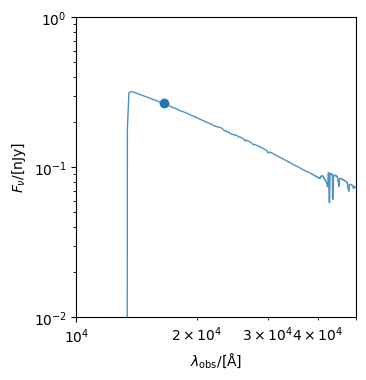

In [175]:

popIII_grid = Grid('yggdrasil-1.3.3-POPIII-fcov_0.5_kroupa-0.1,100.hdf5',
                    grid_dir='/home/tharvey/work/synthesizer_grids/',
                    read_lines=False)


grid = Grid('yggdrasil-1.3.3-PopIII_salpeter-10,1,500.hdf5', #'bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps.hdf5',
                    grid_dir='/home/tharvey/work/synthesizer_grids/',
                    read_lines=False,
)


emission_model = EmissionModel(
    label = 'Pop III',
    extract=popIII_grid.available_spectra[0],
    grid=popIII_grid,
    emitter='stellar'
)



emission_model2 = IncidentEmission(
    grid = grid,

)


galaxy = Galaxy(
    redshift=10,
    stars = Stars(
        grid.log10age,
        grid.metallicity,
        sf_hist = SFH.Constant(max_age=100*Myr, min_age=10*Myr),
        initial_mass = 1e7 * Msun,
        metal_dist = ZDist.DeltaConstant(metallicity=0),
    ),
)
galaxy.stars.get_spectra(emission_model2)

spec = galaxy.get_observed_spectra(cosmo=Planck18)

fig, ax= plot_spectra(
    galaxy.stars.spectra[list(galaxy.stars.spectra.keys())[0]],
    quantity_to_plot='fnu',
    show=False
)

from ltu_ili_testing import calculate_muv
muv = calculate_muv(galaxy, cosmo=Planck18)
ax.scatter(1500*(1+galaxy.redshift), muv['incident'])
ax.set_xlim(10000, 50000)
ax.set_ylim(1e-2, 1)

In [176]:
muv

{'incident': unyt_quantity(0.26661954, 'nJy')}

In [ ]:
from photonion import SPHINXData

sphinx = SPHINXData('/home/tharvey/work/photonion/photonion/all_basic_data.csv')

target = "nion"
fesc_min = 1e-5

In [43]:
output = sphinx.make_Xy(test_fraction=0.2, reweigh_data=True, n_reweigh=5, kind='JADES', target_name=target, fesc_min=fesc_min, muv_norm=True)

In [44]:
output[0][104]

array([14.02409148,  0.19509962, -0.04907673, -0.19696654, -0.22471387,
       -0.23871323, -0.45482417, -0.61975051, 13.82899185,  0.39206616,
        0.42278398, 32.62056393, 10.        ])

In [39]:
import numpy as np

np.argmax(output[0][:, -1])



104

In [ ]:


-2.5 * np.log10(calculate_muv(galaxy, Planck18).to(Jy).value) + 8.9



3.258478742510006e+26 erg/(Hz*s)
0.2666195389927097 nJy


array([32.83527007])

In [ ]:
galaxy.stars.spectra['Pop III'].get_photo_fnu()

In [166]:
popIII_grid = Grid('yggdrasil-1.3.3-PopIII_salpeter-10,1,500',
                    grid_dir='/home/tharvey/work/synthesizer_grids/',
                    read_lines=False)

grid.available_spectra

['incident']

In [9]:
from ltu_ili_testing import draw_from_hypercube

params = {
    'redshift': (6, 14),
    'fraction':(0, 1),
    'tau':(0.05, 2.5),
    'tau_v':(0, 1),
    'peak_age': (-500, 500),
    'logZ': (-3, 0.3),
    'min_popIII_age': (0, 100),
}

params = draw_from_hypercube(1e8, params)

(9, -1, 3, 0.15, 0.3, 0.5)
463.0


(0.0, 486150000.0)

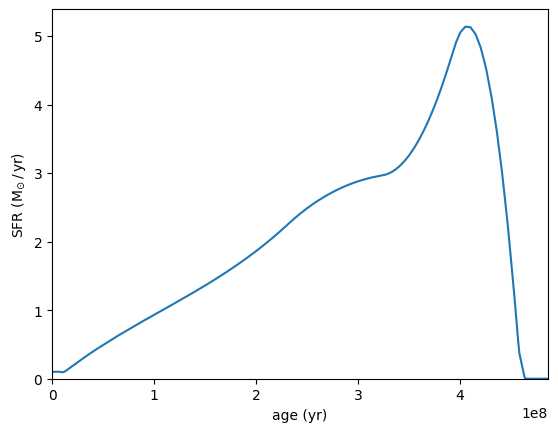

In [52]:
logsfr = -1
times = [0.15,0.3,0.5]
db_tuple = (9, logsfr, 3, *times)
print(db_tuple)
redshift = 10

sfh = SFH.DenseBasis(db_tuple, redshift)

sfh.plot(show=False)
time,sfh=sfh.calculate_sfh()
# last non zero index in SFH

last_non_zero = np.where(sfh > 0)[0][-1]
print(time[last_non_zero]/1e6)
plt.xlim(0, 1.05*time[last_non_zero])

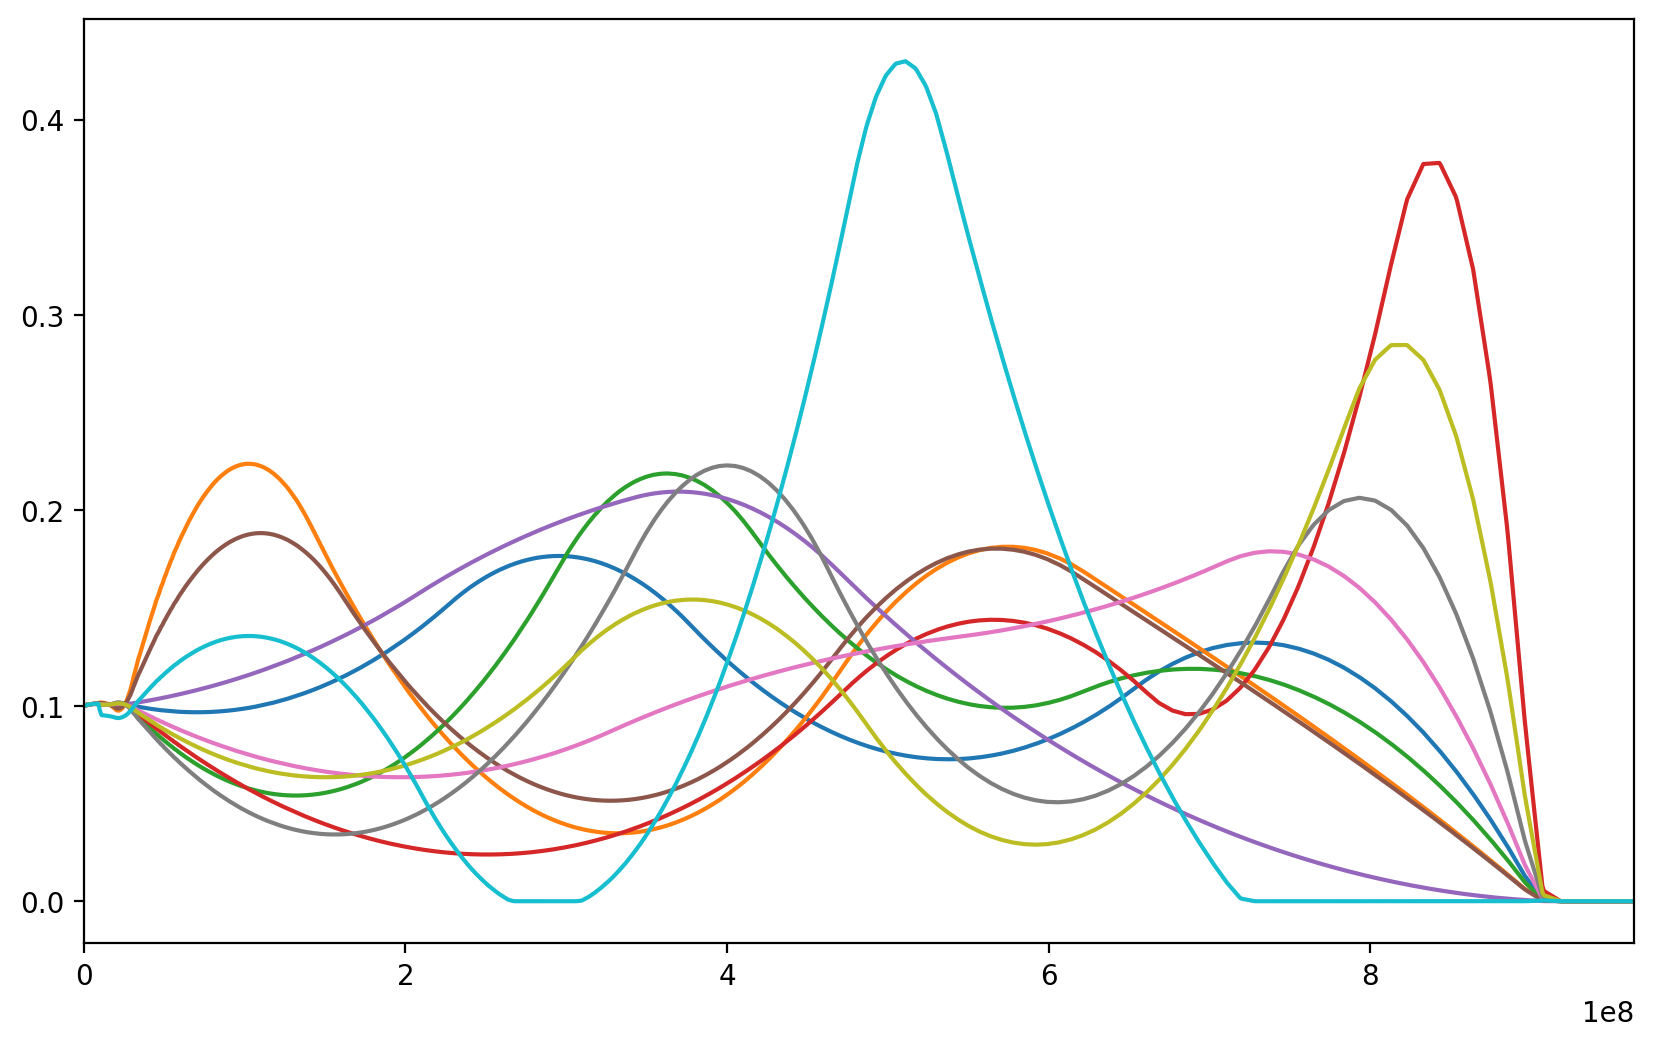

In [71]:
def generate_random_DB_sfh(
    size=1,
    Nparam=3,
    tx_alpha=5,
    redshift=6,
    logmass=8,
    logsfr=-1,
):
    txs = np.cumsum(np.random.dirichlet(np.ones((Nparam+1,))*tx_alpha, size=size),axis=1)[0:,0:-1][0]
    
    db_tuple = (logmass, logsfr, Nparam, *txs)
    sfh = SFH.DenseBasis(db_tuple, redshift)

    return sfh

fig, axs = plt.subplots(1, 1, figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')

for i in range(10):
    sfh = generate_random_DB_sfh(size=1, Nparam=3, tx_alpha=5, redshift=6, logmass=8, logsfr=-1)
    time,sfh=sfh.calculate_sfh()
    # last non zero index in SFH

    last_non_zero = np.where(sfh > 0)[0][-1]
   
    axs.plot(time, sfh)

    axs.set_xlim(0, 1.05*time[last_non_zero])



In [62]:
size = 10
Nparam=5
tx_alpha=5

np.cumsum(np.random.dirichlet(np.ones((Nparam+1,))*tx_alpha, size=size),axis=1)[0:,0:-1]


array([[0.23806632, 0.44151221, 0.5881857 , 0.71660642, 0.8071898 ],
       [0.11541127, 0.3220466 , 0.37941162, 0.71514298, 0.88570587],
       [0.10796055, 0.29700641, 0.47926852, 0.57507245, 0.74679071],
       [0.17480678, 0.32195156, 0.43928033, 0.53529283, 0.69585956],
       [0.23431191, 0.29183093, 0.47196645, 0.64882074, 0.80367238],
       [0.17871958, 0.29079072, 0.41668875, 0.64767224, 0.7930188 ],
       [0.17802842, 0.36571942, 0.60878781, 0.6938609 , 0.87950488],
       [0.25296755, 0.43516189, 0.57816058, 0.6981051 , 0.89779758],
       [0.28068833, 0.41787202, 0.62375865, 0.74524605, 0.89347382],
       [0.13207098, 0.43914835, 0.57231159, 0.71684249, 0.85528465]])

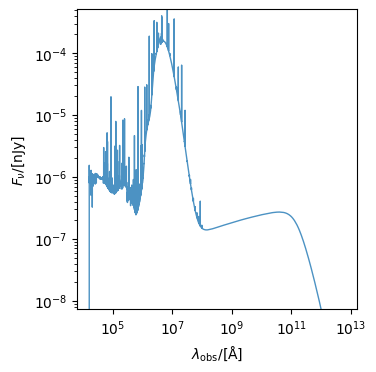

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda_\\mathrm{obs}/[\\mathrm{\\AA}]$', ylabel='$F_{\\nu}/[\\mathrm{\\rm{nJy}}]$'>)

In [95]:


sfh = SFH.LogNormal(peak_age=-308.8170797556386*Myr, tau=0.083540178835392, max_age=800*Myr)

grid = Grid('bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps.hdf5',
            grid_dir='/home/tharvey/work/synthesizer_grids/')

galaxy = Galaxy(
    redshift=12,
    stars = Stars(
        grid.log10age,
        grid.metallicity,
        sf_hist = sfh,
        initial_mass =5.5919 * Msun,
        metal_dist = ZDist.DeltaConstant(log10metallicity=-0.37667277455329895),
        tau_v= 0.22942861914634705,
    ),

)

emission_model = TotalEmission(
    grid=grid,
    fesc=0.1,
    fesc_ly_alpha=0.1,
    dust_curve=Calzetti2000(), 
    dust_emission_model=None,
)


galaxy.stars.get_spectra(emission_model)    

galaxy.get_observed_spectra(cosmo=Planck18, igm=Inoue14)

plot_spectra(
    galaxy.stars.spectra['total'],
    quantity_to_plot='fnu',
    show=True,
)

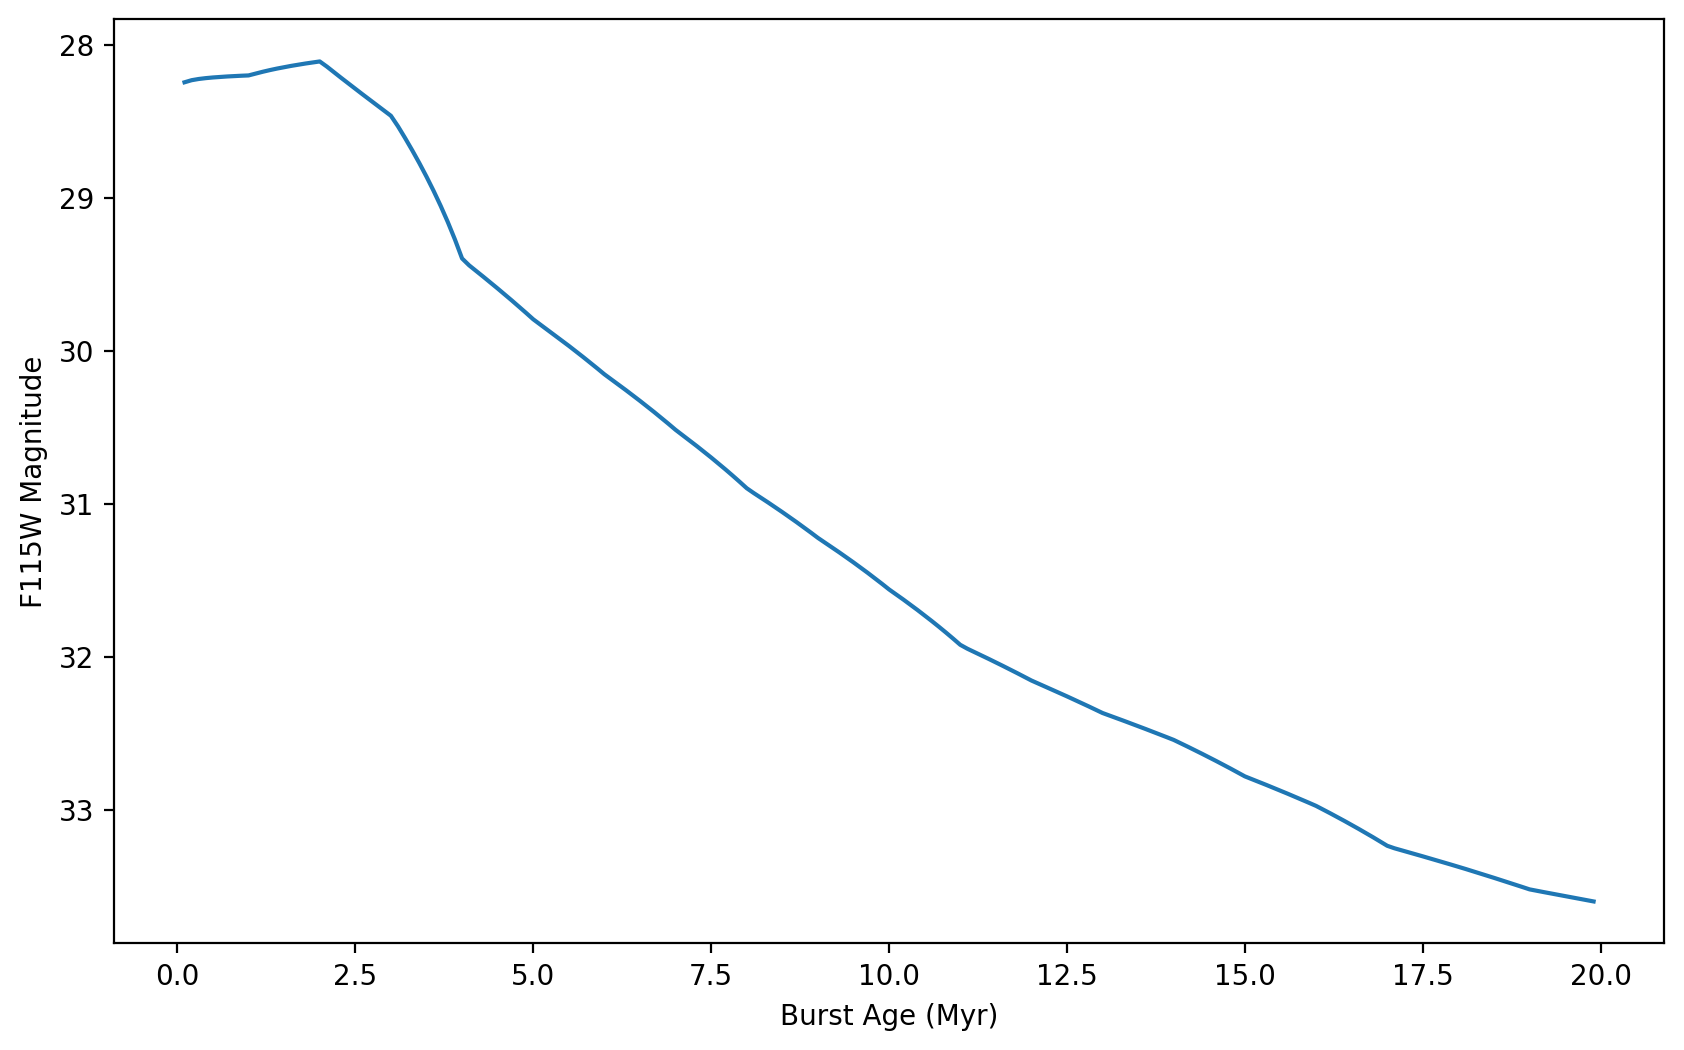

In [45]:
'yggdrasil-1.3.3-PopIII_salpeter-10,1,500',
popIII_grid = Grid('yggdrasil-1.3.3-POPIII-fcov_1_salpeter-10,1,500',
                    grid_dir='/home/tharvey/work/synthesizer_grids/',
                    read_lines=False)

ages = np.arange(0.1, 20, 0.1) * Myr
phots = []
for burst in ages:
    
    stars = Stars(
        popIII_grid.log10age,
        popIII_grid.metallicity,
        sf_hist = burst,
        initial_mass = 1e6 * Msun,
        metal_dist = ZDist.DeltaConstant(metallicity=0),
    )

    galaxy = Galaxy(
        redshift=8,
        stars = stars,
    )

    emission_model = EmissionModel(
        label = 'nebular',
        extract=popIII_grid.available_spectra[0],
        grid=popIII_grid,
        emitter='stellar'
    )

    spectra = galaxy.stars.get_spectra(emission_model=emission_model)

    galaxy.get_observed_spectra(cosmo=Planck18)

    '''plot_spectra(
        galaxy.stars.spectra['Pop_III'],
        quantity_to_plot='fnu',
        #ylimits=(0, 50_000)*Angstrom, 
        #xlimits=(0, 10)*nJy)
    )'''

    phot = galaxy.stars.get_photo_fluxes(instrument.filters)

    mag = -2.5*np.log10(phot['nebular']['JWST/NIRCam.F115W'].to(Jy).value)+8.90
    phots.append(mag)

fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')
ax.plot(ages, phots)
ax.set_xlabel('Burst Age (Myr)')
ax.set_ylabel('F115W Magnitude')
ax.invert_yaxis()


In [20]:
galaxy.stars.spectra['Pop_III'].fnu

unyt_array([1.31538271e-21, 2.08645908e-21, 1.74401573e-21, ...,
       9.87418598e+05, 9.89785546e+05, 9.92166750e+05], shape=(3283,), units='nJy')